In [16]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pickle
import scipy.interpolate as interpolate


import sys, os
sys.path.append(os.path.abspath('..'))
from research.pkg.lib import *
import pygad


# import mplfinance as mpf
%matplotlib inline

plt.rcParams['lines.linewidth'] = 0.5 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [287]:
pair = 'BTC_USDT'
timeframe = '8h'

exchange = 'binance'
odf = pd.read_json(f'../freq-user-data/data/{exchange}/{pair}-{timeframe}.json'
# exchange = 'kucoin'
# odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'
).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=False)
).set_index('dtime').sort_index()

print(odf.shape)
odf.head(4)

(6343, 6)


,timestamp,open,high,low,close,volume
dtime,,,,,,
2017-08-17 00:00:00,1502928000000,4261.48,4349.99,4261.32,4349.99,82.088865
2017-08-17 08:00:00,1502956800000,4333.32,4485.39,4333.32,4352.34,238.181883
2017-08-17 16:00:00,1502985600000,4352.33,4369.69,4200.74,4285.08,474.879629
2017-08-18 00:00:00,1503014400000,4285.08,4340.62,4134.61,4300.25,524.582072


In [3]:
wdf = odf.iloc[-30 * 6:,:]
wdf

,timestamp,open,high,low,close,volume
dtime,,,,,,
2022-12-03,1670025600000,17092.13,17188.98,16858.74,16885.20,154542.57306
2022-12-04,1670112000000,16885.20,17202.84,16878.25,17105.70,178619.13387
2022-12-05,1670198400000,17106.65,17424.25,16867.00,16966.35,233703.29225
2022-12-06,1670284800000,16966.35,17107.01,16906.37,17088.96,218730.76883
2022-12-07,1670371200000,17088.96,17142.21,16678.83,16836.64,220657.41334
...,...,...,...,...,...,...
2023-05-27,1685145600000,26705.93,26895.00,26551.00,26854.27,15095.68670
2023-05-28,1685232000000,26854.28,28261.32,26764.36,28065.00,43916.00855
2023-05-29,1685318400000,28065.01,28447.14,27524.60,27736.40,42385.41945


In [20]:
def plot_candles(wdf, ax, width=0.2, width2=.01):
    up, down = wdf[wdf.close >= wdf.open], wdf[wdf.close < wdf.open]
    col1,col2 = 'green','red'
    # width, width2 = .2, .01
    # Plotting up prices of the stock
    ax.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
    ax.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
    ax.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)
    # Plotting down prices of the stock
    ax.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
    ax.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
    ax.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)   


In [5]:
fibs = np.array([0, 0.236, 0.382, 0.5, 0.618, 0.786, 1])
# dfibs = pd.Series(fibs, index=wdf.index)

xx = np.linspace(0, 1, 100)

a = np.array(
    [ [fib, 0] for fib in fibs] + [[z, (-1) ** (i) * 1 ] for i,z in enumerate((fibs[1:] + fibs[:-1])/2)]
    )
ax, ay = a[a[:, 0].argsort()].T

spline = interpolate.InterpolatedUnivariateSpline(ax, ay)


@interact(x0=(0,wdf.shape[0], 1),x1=(0,wdf.shape[0], 1),x2=(0,wdf.shape[0], 1),xx=(0,wdf.shape[0], 1))
def printer(x0=24,x1=52,x2=119,xx=wdf.shape[0] // 2):
    wlen = wdf.shape[0]
    x_last = wlen - 1
    fig = plt.figure(figsize=(20,9))
    axn = fig.subplots(3,1, sharex=True, height_ratios=[1,1,1])
    ax, ax1, ax2 = axn
    y = wdf.close.values
    idx0, idx1, idx2, idxx = wdf.iloc[[x0,x1,x2, xx]].index.values
    y0, y1, y2 = wdf.close.iloc[[x0,x1,x2]]

    # y_d = y2 - y0
    k = (y2 - y0) / (x2 - x0)
    
    y_lower = (pd.Series(range(wdf.shape[0])) - x1) * k + y1
    y_upper = (pd.Series(range(wdf.shape[0])) - x0) * k + y0


    y_tran = y - y_upper
    y_tran.index = wdf.index
    yt0, yt1, yt2 = y_tran.iloc[[x0,x1,x2]]

    y_fibs =  [y_lower + (y_upper - y_lower) * fib for fib in fibs] +  [y_lower + (y_upper - y_lower) * - fib for fib in fibs] +  [y_lower + (y_upper - y_lower) * (1 + fib) for fib in fibs]
    # y_fibs = [y_lower + (y_upper - y_lower) * fib for fib in fibs] 
    # wdf.close.plot(ax=ax,lw=0.5)
    # ax.set_yscale('symlog')

    # y_d = 
    plt.xticks(rotation=30, ha='right')
    for axs in axn: axs.axvline(idx0, c='r'); axs.axvline(idx1, c='g'); axs.axvline(idx2, c='b');
    for axs in axn: axs.axvline(idxx, linestyle='dashed', c='black');
    ax.axhline(y0, linestyle='dashed');ax.axhline(y1, linestyle='dashed');ax.axhline(y2, linestyle='dashed');
    
    ax.plot(wdf.index[[0,-1]].values,y_upper.iloc[[0,-1]].values, c='maroon')
    ax.plot(wdf.index[[0,-1]].values,y_lower.iloc[[0,-1]].values, c='maroon')

    axtw = ax1.twinx()
    # y_tran.plot(ax=axtw, c='g')
    # axtw.axhline(y_tran[x0]);axtw.axhline(y_tran[x1])
    y_norm = pd.Series( y_tran / yt1, index=wdf.index)

    # y_norm.plot(ax=axtw, c='g', alpha=0.2)
    # y_norm = pd.Series(np.sin( y / y_tran[x1]), index=wdf.index) 
    # y_norm_p = np.cos( - pi / 2 + y_norm * pi)  #/ 2 + 0.5
    y_norm_p = 1- (y_norm  % 1)
    y_norm_p.plot(ax=ax1, c='r')
    # ax1.grid(); ax.grid()
    # dfibs.plot(ax=ax1)

    axtw1 = ax1.twinx()
    # axtw1.plot(wdf.index, spline(y_norm_p), c='g')
    ax2.plot(wdf.index, np.abs(spline(y_norm_p)), c='g')
    ax2.axhline()
    for fib in y_fibs:
        ax.plot(wdf.index[[0,-1]].values,fib.iloc[[0,-1]].values, c='maroon')
    for fib in fibs:
        ax1.axhline(fib)

    
    plot_candles(wdf,ax)
    ax.set_ylim([y.min(), y.max()])
        # ax1.axhline(-fib)


interactive(children=(IntSlider(value=24, description='x0', max=180), IntSlider(value=52, description='x1', ma…

In [6]:
fibs = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]

In [7]:
y = wdf.close.values
xx=0
x0,x1,x2 = 20, 30, 50
# idx0, idx1, idx2, idxx = wdf.iloc[[x0,x1,x2, xx]].index.values
y0, y1, y2 = wdf.close.iloc[[x0,x1,x2]]

# y_d = y2 - y0
k = (y2 - y0) / (x2 - x0)

y_upper = ((pd.Series(range(wdf.shape[0])) - x0) * k + y0)
y_upper.iloc[[0,-1]].values

array([12825.58 , 48204.214])

### Fit fib-levels with B-Splines

/tmp/ipykernel_17480/4011765463.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(fibs, fibs, 'bo', label='Original points', markersize=8, alpha=0.3, c='g')


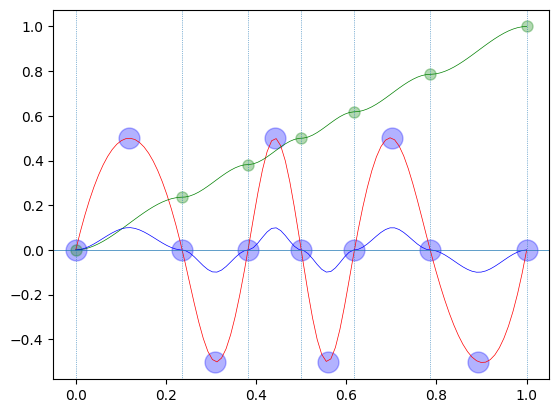

In [8]:
import numpy as np
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
from numpy.polynomial import polynomial as P
from numpy.polynomial.hermite import hermfromroots, hermval
from scipy.fft import fft, ifft, fftfreq, fftshift

fibs = np.array([0, 0.236, 0.382, 0.5, 0.618, 0.786, 1])
x = fibs 
y = np.zeros(len(x))

N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)

a = np.array(
    [ [fib, 0] for fib in fibs] + [[z, (-1) ** (i) * abs(-0.5)  ] for i,z in enumerate((fibs[1:] + fibs[:-1])/2)]
    )
ax, ay = a[a[:, 0].argsort()].T

spline = interpolate.InterpolatedUnivariateSpline(ax, ay)

chspline_step = interpolate.CubicHermiteSpline(x, x, np.zeros(len(x)) , axis=0, extrapolate=None)
chspline = interpolate.CubicHermiteSpline(ax, (ay != 0) * 0.2 * ay, np.zeros(len(ax)) , axis=0, extrapolate=None)

plt.plot(ax, ay, 'bo', label='Original points', markersize=15, alpha=0.3)
plt.plot(fibs, fibs, 'bo', label='Original points', markersize=8, alpha=0.3, c='g')

# plt.plot(x, y, 'bo', label='Original points')
plt.plot(xx, spline(xx), 'r', label='BSpline')
plt.plot(xx,chspline_step(xx), 'g', label='Cubic Hermite-step')
plt.plot(xx,chspline(xx), 'b', label='Cubic Hermite')
plt.axhline()
for f in fibs:
    plt.axvline(f, linestyle='dotted')
# plt.grid()
# plt.legend(loc='best')
# plt.show()

In [9]:

a = np.array(
    [ [fib, 0] for fib in fibs] + [[z, (-1) ** (i) ] for i,z in enumerate((fibs[1:] + fibs[:-1])/2)]
    )
ax, ay = a[a[:, 0].argsort()].T
ay

array([ 0.,  1.,  0., -1.,  0.,  1.,  0., -1.,  0.,  1.,  0., -1.,  0.])

## Fit Fib channels with PyGAD

In [326]:

## Find peaks and troughs
peak_dist = 50
# wstart = odf.shape[0] - 2000
# wlen = 2000
wstart = 0
wend = odf.shape[0]-1
wend = wstart + wlen 
wdf = odf.iloc[wstart:wend]
# ntrain = wdf.shape[0] //  2
train_ratio = 0.7
ntrain = int(wdf.shape[0] * train_ratio)

i_upeaks, _ = find_peaks(wdf.close[:ntrain], distance=peak_dist)
ix_upeaks = wdf.index[i_upeaks]
i_dpeaks, _ = find_peaks(-wdf.close[:ntrain], distance=peak_dist)
ix_dpeaks = wdf.index[i_dpeaks]
# wdf

In [327]:
fibs = np.array([0, 0.236, 0.382, 0.5, 0.618, 0.786, 1])

# x0,x1,x2 = 0, 10, 50
def fitness(pgd, solution, solution_idx):
    # print('solution', solution)
    x0,x1,x2 = solution

    y = wdf.close.values[:ntrain]

    if x2 >= ntrain : return -100;
    if x0 == x1 or x0 == x2 or x1 == x2:
        return -100;
    if x0 >= x1 - peak_dist or x1 >= x2 - peak_dist or x0 >= x2 - peak_dist:
        return -100;

    y0, y1, y2 = wdf.close.iloc[[x0,x1,x2]]
    k = (y2 - y0) / (x2 - x0)

    y_lower = (np.array(range(ntrain)) - x1) * k + y1
    y_upper = (np.array(range(ntrain)) - x0) * k + y0


    y_tran = y - y_upper
    yt0, yt1, yt2 = y_tran[[x0,x1,x2]]

    y_norm = pd.Series( y_tran / yt1)

    # y_norm = pd.Series(np.sin( y / y_tran[x1]), index=wdf.index) 
    # y_norm_p = np.cos( - pi / 2 + y_norm * pi)  #/ 2 + 0.5
    y_norm_p = 1 - (y_norm  % 1)
    s_y_norm = chspline_step(y_norm_p)

    # return np.sum( np.abs(y_norm_p[np.append(i_upeaks, i_dpeaks)]) < 0.05)

    return (
        np.sum(y > y_lower) + np.sum(y < y_upper) +
        np.sum( np.abs(s_y_norm[i_upeaks]) < 0.05) + 
        np.sum( np.abs(s_y_norm[i_dpeaks] - 1) < 0.05)
    )

In [328]:

ga_instance = pygad.GA(num_generations=100,
                    num_parents_mating=2,
                    sol_per_pop=4,
                    num_genes=3,
                    mutation_percent_genes=90,
                    fitness_func=fitness,
                    gene_type=int,
                    allow_duplicate_genes=False,
                    save_best_solutions=True,
                    gene_space=[i_upeaks, 
                                i_dpeaks, 
                                i_upeaks])

ga_instance.run()

print(ga_instance.initial_population)
print(ga_instance.population)
# print(ga_instance.best_solutions)
    

[[ 492  985  545]
 [ 781  574 1218]
 [ 313  316  648]
 [ 781  208 1147]]
[[ 366  519 1270]
 [ 492  627  920]
 [ 545 1083 1270]
 [1338   15  920]]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/pygad/pygad.py:1137: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")


In [329]:

nfibc = 3
np.sort([(nf + fib) for fib in fibs[:-1] for nf in range(-nfibc+1, nfibc)])

array([-2.   , -1.764, -1.618, -1.5  , -1.382, -1.214, -1.   , -0.764,
       -0.618, -0.5  , -0.382, -0.214,  0.   ,  0.236,  0.382,  0.5  ,
        0.618,  0.786,  1.   ,  1.236,  1.382,  1.5  ,  1.618,  1.786,
        2.   ,  2.236,  2.382,  2.5  ,  2.618,  2.786])

In [330]:
fibs = np.array([0, 0.236, 0.382, 0.5, 0.618, 0.786, 1])
# fibs = np.array([0, 0.382, 0.618, 1])
# fibs = np.array([0, 0.236, 0.5,  0.786, 1])
# fibs = np.array([0, 0.5, 1])
# dfibs = pd.Series(fibs, index=wdf.index)
xx = np.linspace(0, 1, 100)


model = 'fib-channels-fitting'
model_params_json = f'./model-params/{model}.json'

a = np.array(
    [ [fib, 0] for fib in fibs] + [[z, (-1) ** (i) * 1 ] for i,z in enumerate((fibs[1:] + fibs[:-1])/2)]
    )
ax, ay = a[a[:, 0].argsort()].T


x0, x1, x2 = ga_instance.best_solutions[-1]
y0, y1, y2 = wdf.close.iloc[[x0,x1,x2]]

# y_d = y2 - y0
k = (y2 - y0) / (x2 - x0)

# spline = interpolate.InterpolatedUnivariateSpline(ax, ay)

chspline_step = interpolate.CubicHermiteSpline(fibs, fibs, np.zeros(len(fibs)) , axis=0, extrapolate=None)
# chspline = interpolate.CubicHermiteSpline(ax, (ay != 0) * 0.1 , np.zeros(len(ax)) , axis=0, extrapolate=None)


model_params = {
}
model_params = {
    **model_params
}
wdgts = [pv['wdg'] for pk, pv in model_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])

if os.path.exists(model_params_json):
    with open(model_params_json) as f: 
        js = json.loads(f.read());
        for k, v in model_params.items(): 
            if k in js: v['wdg'].value=js[k];

else: print(f'File not found: {model_params_json}')

# wdf_norm
y_tran, y_norm, y_norm_p, fib_signal = None, None, None, None
def printer(x0=x0,x1=x1,x2=x2,xx=ntrain):
    global y_tran, y_norm, y_norm_p, fib_signal
    with open(model_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in model_params.items()}))

    wlen = wdf.shape[0]
    x_last = wlen - 1
    fig = plt.figure(figsize=(20,9))
    
    axn = fig.subplots(4,1, sharex=True, height_ratios=[2,1,1,1])
    ax, ax1, ax2, ax3 = axn
    y = wdf.close.values
    idx0, idx1, idx2, idxx = wdf.iloc[[x0,x1,x2, xx]].index.values
    y0, y1, y2 = wdf.close.iloc[[x0,x1,x2]]

    # y_d = y2 - y0
    k = (y2 - y0) / (x2 - x0)
    
    y_lower = (pd.Series(range(wdf.shape[0])) - x1) * k + y1
    y_upper = (pd.Series(range(wdf.shape[0])) - x0) * k + y0


    y_tran = y - y_upper
    y_tran.index = wdf.index
    yt0, yt1, yt2 = y_tran.iloc[[x0,x1,x2]]

    nfibc = 20
    fib_spreads = np.sort([(nf + fib) for fib in fibs[:-1] for nf in range(-nfibc+1, nfibc)])
    y_fibs = [y_lower + (y_upper - y_lower) * f for f in fib_spreads]
    # y_fibs =  [y_lower + (y_upper - y_lower) * fib for fib in fibs] +  [y_lower + (y_upper - y_lower) * - fib for fib in fibs] +  [y_lower + (y_upper - y_lower) * (1 + fib) for fib in fibs]
    # y_fibs = [y_lower + (y_upper - y_lower) * fib for fib in fibs] 
    # wdf.close.plot(ax=ax,lw=0.5)
    # ax.set_yscale('symlog')

    # y_d = 
    plt.xticks(rotation=30, ha='right')
    for axs in axn: axs.axvline(idx0, c='r'); axs.axvline(idx1, c='g'); axs.axvline(idx2, c='b');
    for axs in axn: axs.axvline(idxx, linestyle='dashed', c='black');
    ax.axhline(y0, linestyle='dashed');ax.axhline(y1, linestyle='dashed');ax.axhline(y2, linestyle='dashed');
    
    ax.plot(wdf.index[[0,-1]].values,y_upper.iloc[[0,-1]].values, c='gray')
    ax.plot(wdf.index[[0,-1]].values,y_lower.iloc[[0,-1]].values, c='gray')

    # axtw = ax1.twinx()
    # y_tran.plot(ax=axtw, c='g')
    # axtw.axhline(y_tran[x0]);axtw.axhline(y_tran[x1])
    y_norm = pd.Series( y_tran / yt1, index=wdf.index)

    # wdf_norm_p = wdf[['open', 'high', 'low', 'close']].subtract(y_upper, axis=0).divide(y1).mod(1)

    # y_norm.plot(ax=axtw, c='g', alpha=0.2)
    # y_norm = pd.Series(np.sin( y / y_tran[x1]), index=wdf.index) 
    # y_norm_p = np.cos( - pi / 2 + y_norm * pi)  #/ 2 + 0.5
    y_norm_p = 1- (y_norm  % 1)
    # y_norm_p.plot(ax=ax1, c='r')
    s_y_norm = chspline_step(y_norm_p)
    ax1.plot(wdf.index, s_y_norm, c='g')

    # plot_candles(wdf_norm_p, ax1, width=0.5, width2=0.1)
    # ax1.grid(); ax.grid()
    # dfibs.plot(ax=ax1)

    # axtw1 = ax1.twinx()
    # axtw1.plot(wdf.index, spline(y_norm_p), c='g')
    # ax2.plot(wdf.index, np.abs(spline(y_norm_p)), c='g')
    fib_signal = 1 - chspline(y_norm_p) * 10
    ax2.plot(wdf.index, np.ma.masked_where(fib_signal < 0.9, fib_signal) , c='r')
    ax2.plot(wdf.index, fib_signal , c='b')
    ax2.axhline()
    for fib in y_fibs:
        ax.plot(wdf.index[[0,-1]].values,fib.iloc[[0,-1]].values, c='maroon')
    for fib in fibs:
        ax1.axhline(fib)

    ax3.plot(wdf.index, y_norm)
    for y_fib in y_fibs:
        # ax3.axhline(y_fib)
        # print(y_fib)
        pass
    
    # plot_candles(wdf,ax, width=0.5, width2=0.02)
    wdf.close.plot(ax=ax, lw=0.7, c='b')
    ax.set_ylim([wdf.low.min(), wdf.high.max()])

    ax.scatter(ix_upeaks, wdf.loc[ix_upeaks].close, c='r', alpha=0.3, s=100)
    ax.scatter(ix_dpeaks, wdf.loc[ix_dpeaks].close, c='g', alpha=0.3, s=100)

    ax.set_title('Fitted Fib channels to Bitcoin price')
    ax1.set_title('Normalized Fib channels to interval [0:1]')
    ax2.set_title('Signals generated for approaching fib levels')
    ax2.axhline(0.9, lw=1, c='g')
        # ax1.axhline(-fib)


out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in model_params.items()});
x = display(ui, out);



VBox()

Output()

In [440]:
wdf_norm_p

,open,high,low,close
2022-04-27 00:00:00,NaN,NaN,NaN,NaN
2022-04-28 00:00:00,NaN,NaN,NaN,NaN
2022-04-29 00:00:00,NaN,NaN,NaN,NaN
2022-04-30 00:00:00,NaN,NaN,NaN,NaN
2022-05-01 00:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
194,NaN,NaN,NaN,NaN
195,NaN,NaN,NaN,NaN
196,NaN,NaN,NaN,NaN
197,NaN,NaN,NaN,NaN


## Fit NN 

In [177]:
def flatten_past_n(odf, nper=None, columns=[]):
# plen = 6 * 2
    # if columns is None: columns = odf.columns.tolist()
    pcols = [f'{c}_m{nper-j}' for c in columns for j in range(nper)]
    fdf = pd.DataFrame([
        (
            odf.iloc[i-nper:i].values.flatten()
        )
        #.shape
        for prange in [range(nper,odf.shape[0])]
        for i in prange
    ], index=odf.index.values[nper:]).set_axis(pcols, axis=1)

    return fdf


In [361]:
## add features
xdf = wdf.copy().assign(y_tran = y_tran).assign(y_norm = y_norm).assign(y_norm_p=y_norm_p).assign(fib_signal=fib_signal).drop('timestamp', axis=1)


xdf['bhigh'] = xdf[['open', 'close']].max(axis=1)
xdf['blow'] = xdf[['open', 'close']].min(axis=1)
xdf['brange'] = xdf.bhigh - xdf.blow
xdf['hwick_p'] = xdf.high.divide(xdf.brange + 1e-08).apply(np.log)
xdf['lwick_p'] = xdf.high.divide(xdf.brange + 1e-08).apply(np.log)
# xdf['brange_p'] = xdf.bhigh.divide(xdf.blow + 1e-08).apply(np.log)
xdf['range_p'] = xdf.close.divide(xdf.open + 1e-08).apply(np.log)


xdf

,open,high,low,close,volume,y_tran,y_norm,y_norm_p,fib_signal,bhigh,blow,brange,hwick_p,lwick_p,range_p
dtime,,,,,,,,,,,,,,,
2017-08-17 00:00:00,4261.48,4349.99,4261.32,4349.99,82.088865,-20196.491128,1.788106,0.211894,0.891854,4349.99,4261.48,88.51,3.894813,3.894813,0.020557
2017-08-17 08:00:00,4333.32,4485.39,4333.32,4352.34,238.181883,-20180.251781,1.786668,0.213332,0.903471,4352.34,4333.32,19.02,5.463090,5.463090,0.004380
2017-08-17 16:00:00,4352.33,4369.69,4200.74,4285.08,474.879629,-20233.622434,1.791393,0.208607,0.863348,4352.33,4285.08,67.25,4.174030,4.174030,-0.015572
2017-08-18 00:00:00,4285.08,4340.62,4134.61,4300.25,524.582072,-20204.563086,1.788820,0.211180,0.885883,4300.25,4285.08,15.17,5.656453,5.656453,0.003534
2017-08-18 08:00:00,4285.00,4371.52,4193.70,4236.89,372.109513,-20254.033739,1.793200,0.206800,0.846599,4285.00,4236.89,48.11,4.509376,4.509376,-0.011291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-14 00:00:00,8216.44,8244.18,8144.32,8239.29,7526.653937,11402.056825,-1.009486,0.009486,0.981650,8239.29,8216.44,22.85,5.888312,5.888312,0.002777
2019-06-14 08:00:00,8238.14,8458.58,8231.60,8385.16,16483.800311,11561.816173,-1.023631,0.023631,0.895750,8385.16,8238.14,147.02,4.052368,4.052368,0.017689
2019-06-14 16:00:00,8385.93,8684.41,8311.00,8650.00,15824.792007,11840.545520,-1.048308,0.048308,0.634426,8650.00,8385.93,264.07,3.493071,3.493071,0.031004


In [362]:
# fkdf = xdf[['open']]
fkdf = xdf
xdf = flatten_past_n(fkdf, nper=3*3, columns=fkdf.columns).join(xdf)
xdf = xdf.assign(k=k
).assign(dow=xdf.index.dayofweek
).assign(hour=xdf.index.hour
).assign(std_5=xdf.close.rolling(5).std().bfill())
xdf

,open_m9,open_m8,open_m7,open_m6,open_m5,open_m4,open_m3,open_m2,open_m1,high_m9,...,bhigh,blow,brange,hwick_p,lwick_p,range_p,k,dow,hour,std_5
2017-08-20 00:00:00,4261.48,4349.99,4261.32,4349.99,82.088865,-20196.491128,1.788106,0.211894,0.891854,4349.99,...,4155.87,4120.98,34.89,4.780243,4.780243,0.008431,-13.889347,6,0,55.435911
2017-08-20 08:00:00,4333.32,4485.39,4333.32,4352.34,238.181883,-20180.251781,1.786668,0.213332,0.903471,4352.34,...,4155.87,4125.00,30.87,4.915690,4.915690,-0.007456,-13.889347,6,8,55.435911
2017-08-20 16:00:00,4352.33,4369.69,4200.74,4285.08,474.879629,-20233.622434,1.791393,0.208607,0.863348,4352.33,...,4125.00,4086.29,38.71,4.683389,4.683389,-0.009429,-13.889347,6,16,55.435911
2017-08-21 00:00:00,4285.08,4340.62,4134.61,4300.25,524.582072,-20204.563086,1.788820,0.211180,0.885883,4300.25,...,4069.13,4043.63,25.50,5.084838,5.084838,-0.006286,-13.889347,0,0,55.435911
2017-08-21 08:00:00,4285.00,4371.52,4193.70,4236.89,372.109513,-20254.033739,1.793200,0.206800,0.846599,4285.00,...,4043.63,4022.00,21.63,5.241759,5.241759,-0.005364,-13.889347,0,8,55.435911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-14 00:00:00,7981.00,8010.00,7860.17,7897.56,8356.688006,10935.322699,-0.968164,0.968164,0.787099,7981.00,...,8239.29,8216.44,22.85,5.888312,5.888312,0.002777,-13.889347,4,0,59.445968
2019-06-14 08:00:00,7897.56,7936.08,7706.83,7761.53,12656.530624,10813.182046,-0.957350,0.957350,0.650018,7897.56,...,8385.16,8238.14,147.02,4.052368,4.052368,0.017689,-13.889347,4,8,105.827317
2019-06-14 16:00:00,7761.92,7947.98,7692.23,7884.90,9321.780797,10950.441394,-0.969502,0.969502,0.802593,7884.90,...,8650.00,8385.93,264.07,3.493071,3.493071,0.031004,-13.889347,4,16,194.279381
2019-06-15 00:00:00,7884.90,8045.00,7788.99,7960.16,13541.729304,11039.590741,-0.977395,0.977395,0.884965,7960.16,...,8657.15,8650.88,6.27,7.237598,7.237598,0.000725,-13.889347,5,0,213.947061


In [339]:

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [364]:

# xdf = odf.join(fhdf).dropna().iloc[-2048:,:]
# wlen = 6 * 2

# fdf = pd.DataFrame([
#     (
#         odf.iloc[i-wlen:i].values.flatten()
#     )
#     #.shape
#     for i in range(wlen,odf.shape[0])
# ], index=odf.index.values[wlen:])

# xdf = odf.join(fdf).join(edf).dropna()

# xdf.columns


timeout = 3
r2r = 2. / 1.
target_pct = 0.02
#################
# fu_highs = dxdf.high.rolling(timeout).max().shift(-timeout)
# fu_high_rets = fu_highs.divide(dxdf.close).apply(np.log).fillna(0).round(3)
# fu_lows = dxdf.low.rolling(timeout).min().shift(-timeout)
# fu_low_rets = fu_lows.divide(dxdf.close).apply(np.log).fillna(0).round(3)
#################

fu_highs = xdf.close.rolling(timeout).max().shift(-timeout)
fu_high_rets = fu_highs.divide(xdf.close).apply(np.log).fillna(0).round(3)
fu_lows = xdf.close.rolling(timeout).min().shift(-timeout)
fu_low_rets = fu_lows.divide(xdf.close).apply(np.log).fillna(0).round(3)
fu_r2r = - fu_low_rets / fu_high_rets
fu_rets = xdf.close.rolling(timeout).max().shift(-timeout).divide(xdf.close).apply(np.log).fillna(0).round(3)
# fu_rets
# qs = np.quantile(fu_rets, np.linspace(0,1,6))
# y_cut, y_bins = pd.qcut(fu_rets, np.linspace(0,1,8), retbins=True)
# y = y_cut.map(lambda x: x.right).astype(float).values 
cats = pd.DataFrame(
    # xdf.range_p >0
    (fu_rets >= target_pct) 
    # (fu_high_rets >= target_pct)
        # (fu_rets >= target_ret) & (fu_dds >= sl_ret)
        # fu_lows < ema - stds * 3
    # & (fu_high_rets / (- fu_low_rets) > r2r)
        # np.where( fu_r2r < 1/2.5 , 1, np.where(fu_r2r > 2.5, 1, 0))
        # & (fu_low_rets > 0.01)
        # fu_low_rets > -0.01
     , index=xdf.index).dropna()#.astype(str)


# wsel = cats.shape[0] // 2
# sel_cats = cats.iloc[wsel:]
sel_cats = cats
y = sel_cats.values.ravel()
Xdf = xdf.loc[sel_cats.index] #.values

# iX_train, iX_test, y_train, y_test = train_test_split(i_samples, y, random_state=1, test_size=0.8)
Xdf_train, Xdf_test, y_train, y_test = train_test_split(Xdf, y, random_state=7, shuffle=False, test_size=train_ratio)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.7)
X_train, X_test, = Xdf_train.values, Xdf_test.values

clf = MLPClassifier(solver='adam', max_iter=300, verbose=False, batch_size=1024, 
                    activation='tanh', epsilon=1e-10, hidden_layer_sizes=(256,256,128,32)
                #     learning_rate_init = 1e-4,
                    )

scaler = StandardScaler().fit([*X_train, *X_test])

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

m = clf.fit(X_train_norm, y_train)

y_pred_train =  m.predict(X_train_norm)
y_pred_test =  m.predict(X_test_norm)

accuracy_train = accuracy_score(y_train,y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
# y_pred_proba = m.predict_proba(X_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
# auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
# fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba[:,1])

# print('ROC curve (area = {:0.2f})'.format(auc_score))
print(f'Acc(train)={accuracy_train:.2f}\tAcc(test)={accuracy_train:.2f}')
print(f'Precision(Train)={precision_train:.2f}\tRecall(Train)={recall_train:.2f}')
print(f'Precision(Test)={precision_test:.2f}\tRecall(Test)={recall_test:.2f}')
print(f'----------- Classification Report: ------------')
report = classification_report(y_test, y_pred_test)
print(report)

/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


Acc(train)=1.00	Acc(test)=1.00
Precision(Train)=1.00	Recall(Train)=1.00
Precision(Test)=0.26	Recall(Test)=0.47
----------- Classification Report: ------------
              precision    recall  f1-score   support

       False       0.76      0.56      0.64      1051
        True       0.26      0.47      0.33       343

    accuracy                           0.53      1394
   macro avg       0.51      0.51      0.49      1394
weighted avg       0.64      0.53      0.57      1394



Index([ 0,  8, 16,  0,  8, 16,  0,  8, 16,  0,
       ...
        8, 16,  0,  8, 16,  0,  8, 16,  0,  8],
      dtype='int32', name='dtime', length=2000)